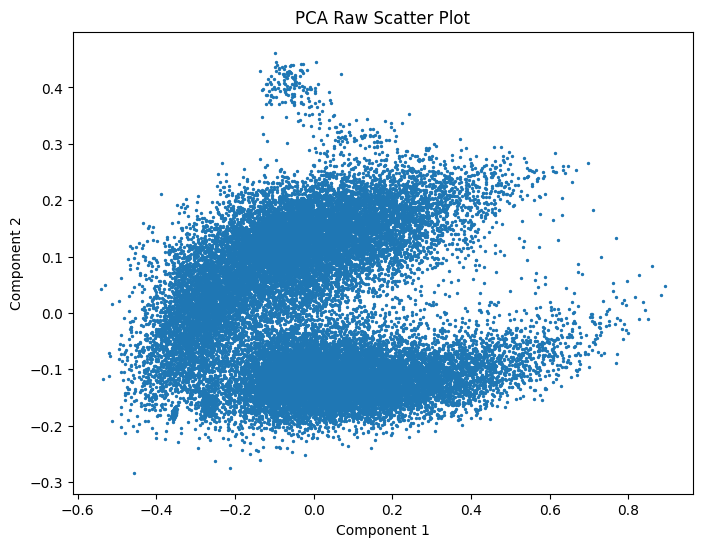

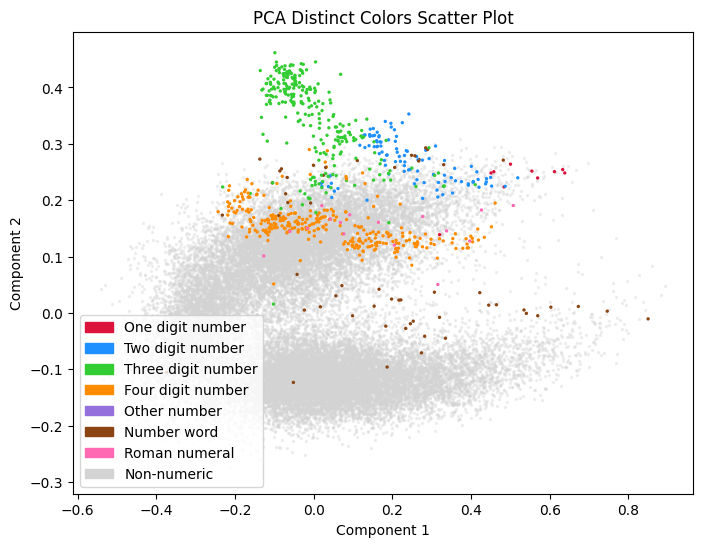

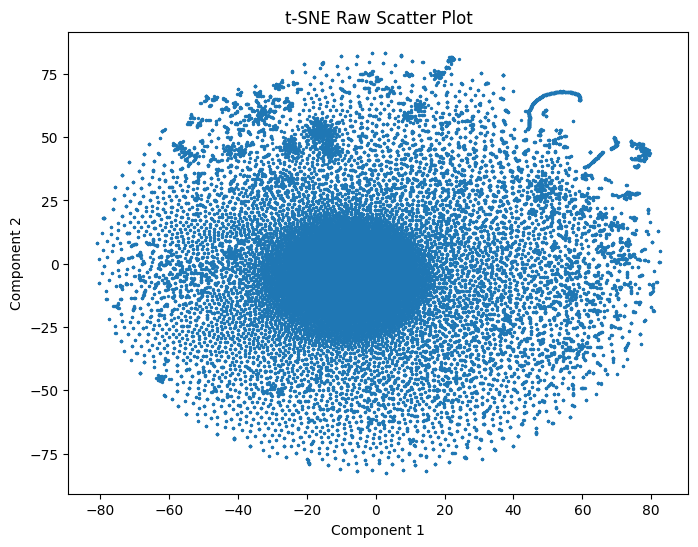

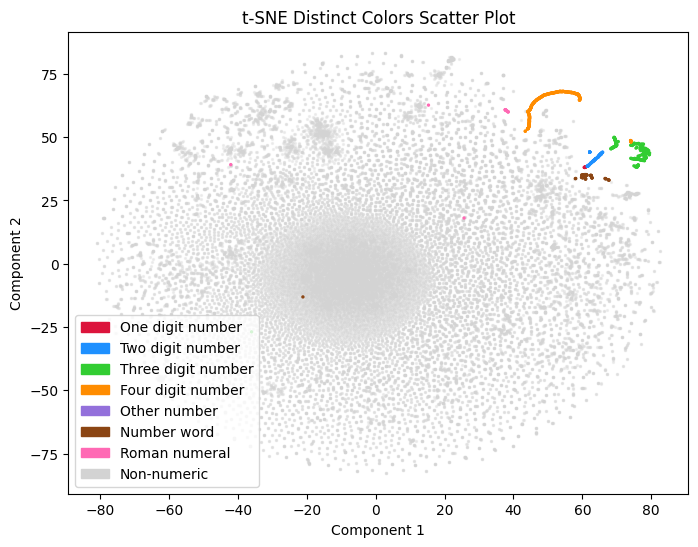

/Users/ramiluisto/anaconda3/envs/GenEnv11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



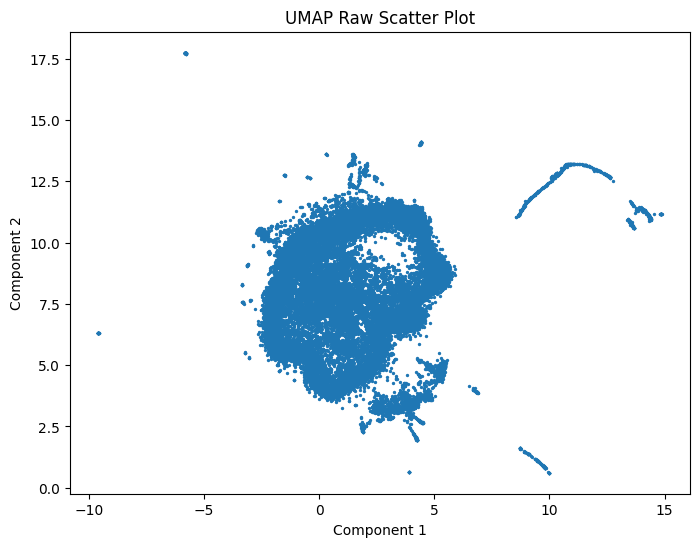

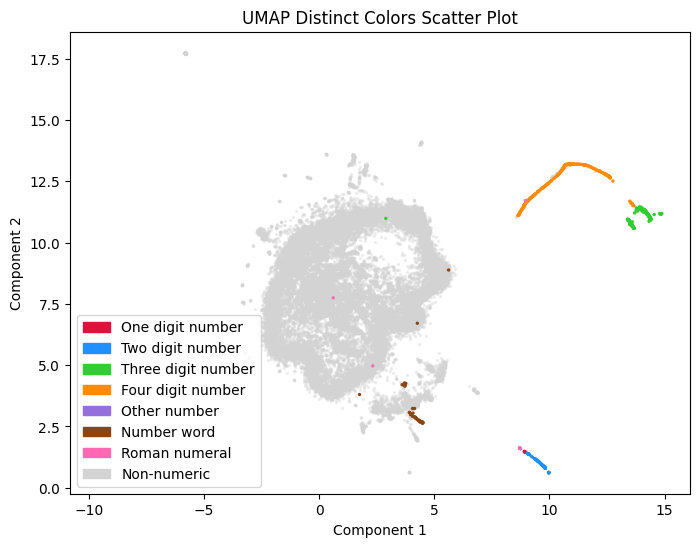

In [22]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.graph_objects as go
import umap.umap_ as umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
from transformers import BertModel, BertTokenizer

model = BertModel.from_pretrained("bert-base-cased")
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
embeddings = model.get_input_embeddings().weight.data.numpy()
tokens = [tokenizer.convert_ids_to_tokens(i) for i in range(tokenizer.vocab_size)]

def reduce_embeddings(method, emb):
    if method == 'PCA':
        reducer = PCA(n_components=2)
    elif method == 't-SNE':
        reducer = TSNE(n_components=2, random_state=42)
    elif method == 'UMAP':
        reducer = umap.UMAP(n_components=2, random_state=42)
    else:
        raise ValueError(f"Unknown reduction method: {method}")
    return reducer.fit_transform(emb)

number_words = {"one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten",
                "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen", "seventeen",
                "eighteen", "nineteen", "twenty", "thirty", "forty", "fifty", "sixty", "seventy",
                "eighty", "ninety", "hundred", "thousand", "million", "billion", "trillion"}

roman_numerals = {num for num in ["I", "II", "III", "IV", "V", "VI", "VII", "VIII", "IX", "X",
                                   "XI", "XII", "XIII", "XIV", "XV", "XVI", "XVII", "XVIII", "XIX", "XX",
                                   "XXI", "XXII", "XXIII", "XXIV", "XXV", "XXVI", "XXVII", "XXVIII", "XXIX", "XXX",
                                   "XL", "L", "LX", "LXX", "LXXX", "XC", "C", "CC", "CCC", "CD", "D",
                                   "DC", "DCC", "DCCC", "CM", "M", "MM", "MMM", "MMMM"] if len(num) > 1}

def get_color(token):
    if re.fullmatch(r'\d+', token):
        if len(token) == 1:
            return "crimson"
        elif len(token) == 2:
            return "dodgerblue"
        elif len(token) == 3:
            return "limegreen"
        elif len(token) == 4:
            return "darkorange"
        else:
            return "mediumpurple"
    elif token.lower() in number_words:
        return "saddlebrown"
    elif token in roman_numerals:
        return "hotpink"
    else:
        return "lightgray"

def get_category(token):
    if re.fullmatch(r'\d+', token):
        if len(token) == 1:
            return "One digit number"
        elif len(token) == 2:
            return "Two digit number"
        elif len(token) == 3:
            return "Three digit number"
        elif len(token) == 4:
            return "Four digit number"
        else:
            return "Other number"
    elif token.lower() in number_words:
        return "Number word"
    elif token in roman_numerals:
        return "Roman numeral"
    else:
        return "Non-numeric"

category_to_color = {
    "One digit number": "crimson",
    "Two digit number": "dodgerblue",
    "Three digit number": "limegreen",
    "Four digit number": "darkorange",
    "Other number": "mediumpurple",
    "Number word": "saddlebrown",
    "Roman numeral": "hotpink",
    "Non-numeric": "lightgray"
}

def plot_scatter(reduced, title, xlabel="Component 1", ylabel="Component 2", colors=None):
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], c=colors, s=2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_interactive_legend_scatter(reduced, tokens, title):
    categories = [get_category(tok) for tok in tokens]
    df = pd.DataFrame({
         "x": reduced[:, 0],
         "y": reduced[:, 1],
         "token": tokens,
         "category": categories
    })
    fig = go.Figure()
    # Add non-numeric tokens as one trace with lower opacity.
    df_non = df[df["category"] == "Non-numeric"]
    if not df_non.empty:
        fig.add_trace(go.Scattergl(
            x=df_non["x"],
            y=df_non["y"],
            mode="markers",
            marker=dict(color=category_to_color["Non-numeric"], size=4, opacity=0.3),
            name="Non-numeric",
            text=df_non["token"],
            hoverinfo="text"
        ))
    # Add numeric tokens grouped by category.
    for cat, color in category_to_color.items():
        if cat == "Non-numeric":
            continue
        df_cat = df[df["category"] == cat]
        if not df_cat.empty:
            fig.add_trace(go.Scattergl(
                x=df_cat["x"],
                y=df_cat["y"],
                mode="markers",
                marker=dict(color=color, size=4),
                name=cat,
                text=df_cat["token"],
                hoverinfo="text"
            ))
    fig.update_layout(title=title, xaxis_title="Component 1", yaxis_title="Component 2")
    fig.show()

def plot_legend_scatter(reduced, tokens, title):
    colors = np.array([get_color(tok) for tok in tokens])
    non_numeric_idx = [i for i, col in enumerate(colors) if col == "lightgray"]
    numeric_idx = [i for i, col in enumerate(colors) if col != "lightgray"]

    plt.figure(figsize=(8, 6))
    if non_numeric_idx:
        plt.scatter(reduced[non_numeric_idx, 0], reduced[non_numeric_idx, 1],
                    c="lightgray", s=2, alpha=0.3, zorder=1)
    if numeric_idx:
        numeric_colors = colors[numeric_idx]
        plt.scatter(reduced[numeric_idx, 0], reduced[numeric_idx, 1],
                    c=numeric_colors, s=2, zorder=2)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    legend_handles = [
        mpatches.Patch(color="crimson", label="One digit number"),
        mpatches.Patch(color="dodgerblue", label="Two digit number"),
        mpatches.Patch(color="limegreen", label="Three digit number"),
        mpatches.Patch(color="darkorange", label="Four digit number"),
        mpatches.Patch(color="mediumpurple", label="Other number"),
        mpatches.Patch(color="saddlebrown", label="Number word"),
        mpatches.Patch(color="hotpink", label="Roman numeral"),
        mpatches.Patch(color="lightgray", label="Non-numeric")
    ]
    plt.legend(handles=legend_handles, loc="lower left")
    plt.show()

methods = ["PCA", "t-SNE", "UMAP"]

for method in methods:
    reduced = reduce_embeddings(method, embeddings)
    plot_scatter(reduced, f"{method} Raw Scatter Plot")
    # Removed gradient plot.
    plot_interactive_legend_scatter(reduced, tokens, f"{method} Interactive Scatter Plot")
    plot_legend_scatter(reduced, tokens, f"{method} Distinct Colors Scatter Plot")


In [18]:
import re

digit_re = re.compile(r'^[0-9]+$')

def check_how_many_n_digit_numbers_are_tokens(n):
    return sum(1 for token in tokens if digit_re.fullmatch(token) and len(token) == n)

for i in range(1, 10):
    count = check_how_many_n_digit_numbers_are_tokens(i)
    print(f"Number of {i}-digit numbers that are tokens: {count}")
    print(f"Percentage of {i}-digit numbers that are tokens: {count / 10**i * 100:.2f}%")
    print()


Number of 1-digit numbers that are tokens: 10
Percentage of 1-digit numbers that are tokens: 100.00%

Number of 2-digit numbers that are tokens: 100
Percentage of 2-digit numbers that are tokens: 100.00%

Number of 3-digit numbers that are tokens: 258
Percentage of 3-digit numbers that are tokens: 25.80%

Number of 4-digit numbers that are tokens: 304
Percentage of 4-digit numbers that are tokens: 3.04%

Number of 5-digit numbers that are tokens: 0
Percentage of 5-digit numbers that are tokens: 0.00%

Number of 6-digit numbers that are tokens: 0
Percentage of 6-digit numbers that are tokens: 0.00%

Number of 7-digit numbers that are tokens: 0
Percentage of 7-digit numbers that are tokens: 0.00%

Number of 8-digit numbers that are tokens: 0
Percentage of 8-digit numbers that are tokens: 0.00%

Number of 9-digit numbers that are tokens: 0
Percentage of 9-digit numbers that are tokens: 0.00%



In [21]:
years = [token for token in tokens if digit_re.fullmatch(token) and len(token) == 4]
years.sort()
years

['1000',
 '1100',
 '1200',
 '1300',
 '1400',
 '1500',
 '1600',
 '1620',
 '1640',
 '1642',
 '1644',
 '1648',
 '1650',
 '1660',
 '1661',
 '1680',
 '1688',
 '1689',
 '1690',
 '1700',
 '1710',
 '1715',
 '1720',
 '1730',
 '1740',
 '1745',
 '1746',
 '1747',
 '1748',
 '1749',
 '1750',
 '1751',
 '1752',
 '1753',
 '1754',
 '1755',
 '1756',
 '1757',
 '1758',
 '1759',
 '1760',
 '1761',
 '1762',
 '1763',
 '1764',
 '1765',
 '1766',
 '1767',
 '1768',
 '1769',
 '1770',
 '1771',
 '1772',
 '1773',
 '1774',
 '1775',
 '1776',
 '1777',
 '1778',
 '1779',
 '1780',
 '1781',
 '1782',
 '1783',
 '1784',
 '1785',
 '1786',
 '1787',
 '1788',
 '1789',
 '1790',
 '1791',
 '1792',
 '1793',
 '1794',
 '1795',
 '1796',
 '1797',
 '1798',
 '1799',
 '1800',
 '1801',
 '1802',
 '1803',
 '1804',
 '1805',
 '1806',
 '1807',
 '1808',
 '1809',
 '1810',
 '1811',
 '1812',
 '1813',
 '1814',
 '1815',
 '1816',
 '1817',
 '1818',
 '1819',
 '1820',
 '1821',
 '1822',
 '1823',
 '1824',
 '1825',
 '1826',
 '1827',
 '1828',
 '1829',
 '1830',
 